In [1]:
import os

In [2]:
dargs = {
    'ROOT_DIR': 'C:/Users/ericotjoa/Desktop/xaia',
    'label_name': 'cff-sqann',    
    'CREDIT_FRAUD_DATA_DIR': 'C:/data/ulb-ml-group-fraud-dataset/creditcard.csv',
    
    'n_split_negative':(2500,2500,2500),
    'n_mult_positive':5,
}

os.chdir(dargs['ROOT_DIR'])

In [3]:
from SQANN.utils.creditcardfraud import *
from SQANN.utils.continuous_eval import standard_evaluation_cont, compute_discrete_error
DIRS = manage_dirs_creditcardfraud(dargs)

In [4]:
if len(os.listdir(DIRS['CCF_RECONSTRUCT_FOLDER_DIR'])) ==0 :
    creditcardfraud_reconstruct_data(dargs)
else:
    print('reconstructed data already exist')

reconstructed data already exist


In [5]:
def normalize(X):
    return np.clip(X, a_min=-3., a_max=3.) + 0.5

In [6]:
n_train = 256
df = pd.read_csv(DIRS['REC_TRAIN_DATA_DIR'], float_precision='high', index_col=False)
print(df.columns)
print('df.size:',df.size)

# Note: the dataframe has been constructed so that the first half has label 0
# and the second half has label 1

X_train = df[[f'V{i}' for i in range(1,1+28)]].to_numpy()
Y_train = df[['Class']].to_numpy().reshape(-1)
X_train = normalize(X_train) 

tmp = []
tmp_y = []
for i in range(n_train):
    tmp.append(X_train[i*dargs['n_mult_positive'],:])
    tmp.append(X_train[-i*dargs['n_mult_positive']-1,:])
    tmp_y.append(Y_train[i*dargs['n_mult_positive']])
    tmp_y.append(Y_train[-i*dargs['n_mult_positive']-1])
X_train = np.array(tmp)    
Y_train = np.array(tmp_y)

print(X_train.shape)
print(Y_train[:10])

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class'],
      dtype='object')
df.size: 143811
(512, 28)
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


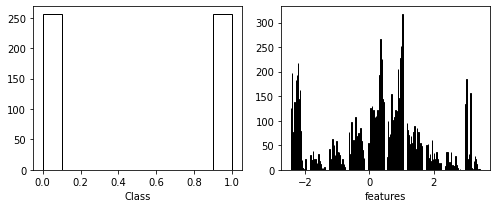

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
plt.gcf().add_subplot(1,2,1)
plt.gca().hist(Y_train, fill=False)
plt.gca().set_xlabel('Class')
plt.gcf().add_subplot(1,2,2)
plt.gca().hist(X_train, fill=False)
plt.gca().set_xlabel('features')
plt.tight_layout()
print()

In [8]:
df_test = pd.read_csv(DIRS['REC_TEST_DATA_DIR'], float_precision='high', index_col=False)

X_test = df[[f'V{i}' for i in range(1,1+28)]].to_numpy()
Y_test = df[['Class']].to_numpy().reshape(-1)
X_test = normalize(X_test) 

print(X_test.shape)
print(Y_test[:5], Y_test[-5:])

(4959, 28)
[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


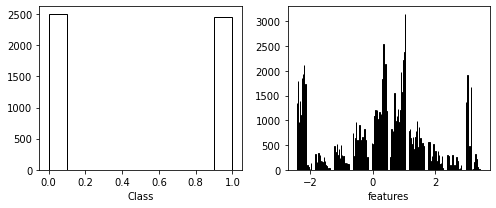

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
plt.gcf().add_subplot(1,2,1)
plt.gca().hist(Y_test, fill=False)
plt.gca().set_xlabel('Class')
plt.gcf().add_subplot(1,2,2)
plt.gca().hist(X_test, fill=False)
plt.gca().set_xlabel('features')
plt.tight_layout()
print()

In [10]:
MDE = {} 
from sklearn.linear_model import LinearRegression, Ridge,  Lasso
def do_regress(regression, X_train, Y_train, MDE, name):
    model = regression.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    if name is not None:
        MDE[name] = compute_discrete_error(Y_pred,Y_test)
    return MDE

print('linear models...')
MDE = do_regress( LinearRegression(), X_train, Y_train, MDE, 'linear')
MDE = do_regress(Ridge(), X_train, Y_train, MDE,'Ridge')
MDE = do_regress(Lasso(), X_train, Y_train, MDE, 'Lasso')

print('\nSupport vector models...')
from sklearn.svm import LinearSVR, NuSVR, SVR
MDE = do_regress(LinearSVR(), X_train, Y_train, MDE,'LinSVR')
MDE = do_regress(NuSVR(), X_train, Y_train, MDE,'NuSVR')
MDE = do_regress(SVR(), X_train, Y_train, MDE,'SVR')

print('\nDecision Tree models...')
from sklearn.tree import DecisionTreeRegressor
MDE = do_regress(DecisionTreeRegressor(random_state=0), X_train, Y_train, MDE,'DecTree')

print('\nKNeighbors models...')
from sklearn.neighbors import KNeighborsRegressor
min_MDE,n_min = np.inf,-1
for n in range(2,16+1):
    temp_name = 'KNeighborsRegressor(n_neighbors=%s)'%(str(n))
    dummy = do_regress(KNeighborsRegressor(n_neighbors=n), X_train, Y_train, {}, temp_name)
    this_MDE = dummy[temp_name]
    if this_MDE<min_MDE:
        print(np.round(this_MDE,4), 'n:%s'%(str(n)))
        min_MDE = this_MDE
        n_min = n
MDE['kneigh'] = min_MDE

print('\nMLP models...')
from sklearn.neural_network import MLPRegressor
MDE = do_regress(MLPRegressor(hidden_layer_sizes=(64,64),random_state=1, max_iter=12000), X_train, Y_train, MDE, 'MLP')

linear models...

Support vector models...


c:\users\ericotjoa\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Decision Tree models...

KNeighbors models...
0.0127 n:2

MLP models...


In [11]:
from src.model import SQANN, double_selective_activation
from src.utils import make_layer_setting, simple_evaluation, standard_evaluation

# as of now, we are doing parameter search manually though
# the results very much depends on the preprocessing too, as usual
a1 = 0.001
a2 = 0.5
t_admission = 0.1
t_threshold = 0.8

MAX_LAYER = 16
layer_settings = {
    # make_layer_setting(a1, a2,  admission_threshold, activation_threshold, max_n)
    i: make_layer_setting(a1, a2,t_admission-0.01*i, t_threshold, ) for i in range(1,1+MAX_LAYER) # BEST NOW
}

net = SQANN(layer_settings, N=len(X_train))
net.fit_data(X_train,Y_train,verbose=20)

# Show zero errors on training dataset! (Theorem 2 in the paper)
standard_evaluation(X_train, Y_train, net, get_interp_indices=False)


Exiting layer_k_sample_collection() because all data have been used.
Final positions of indices in the layers:
  [1] [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374

[182]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[183]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[184]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[185]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[186]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[187]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[188]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[189]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[190]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[191]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[192]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[193]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[194]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[195]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[196]  L=1         |(0.0  ) - (0.0

[350]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[351]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[352]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[353]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[354]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[355]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[356]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[357]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[358]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[359]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[360]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[361]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[362]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[363]  L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[364]  L=1         |(0.0  ) - (0.0

{'N_INTERPOLATED': 0,
 'mean_error': 0.0,
 'mean_frac_error': 0.5,
 'mean_ex_error': 0.0,
 'mean_ex_frac_error': 0.5}

In [12]:
standard_evaluation_cont(X_test, Y_test, net, get_interp_indices=False)
Y_pred = []
for i in range(len(X_test)):
    y, act, ACTIVATION_STATUS, info_ = net.SQANN_propagation(X_test[i,:], ALLOW_INTERPOLATION=True)
    Y_pred.append(y)
MDE['SQANN'] = compute_discrete_error(np.array(Y_pred),Y_test)

 i     Layer     |y-y0|                           abs error
[0]    L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[3]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[4]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[5]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[6]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[7]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[8]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[9]    L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[10]   L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[11]   L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[12]   L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[13]   L=2         |(0.0  ) - (0.0  ))|    

[127]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[128]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[129]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[130]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[131]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[132]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[133]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[134]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[135]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[136]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[137]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[138]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[139]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[140]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[141]  L=2         |(0.0  ) - (0.0

[248]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[249]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[250]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[251]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[252]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[253]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[254]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[255]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[256]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[257]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[258]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[259]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[260]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[261]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[262]  L=2         |(0.0  ) - (0.0

[467]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[468]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[469]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[470]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[471]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[472]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[473]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[474]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[475]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[476]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[477]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[478]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[479]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[480]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[481]  L=2         |(0.0  ) - (0.0

[723]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[724]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[725]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[726]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[727]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[728]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[729]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[730]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[731]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[732]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[733]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[734]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[735]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[736]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[737]  L=2         |(0.0  ) - (0.0

[972]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[973]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[974]  L=4         |(0.0  ) - (0.0  ))|                 0.0      HIT
[975]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[976]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[977]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[978]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[979]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[980]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[981]  L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[982]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[983]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[984]  L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[985]  L=1         |(0.0  ) - (0.0  ))|                 0.0      HIT
[986]  L=2         |(0.0  ) - (0.0

[1213] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1214] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1215] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1216] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1217] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[1218] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1219] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[1220] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1221] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1222] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1223] L=[1, 3]    |(0.0  ) - (0.0  ))|                 0.0      INTERPOLATE
[1224] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1225] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1226] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1227] L=2         |(0.0  

[1425] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1426] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1427] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1428] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[1429] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1430] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1431] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1432] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1433] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1434] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1435] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1436] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1437] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1438] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1439] L=2         |(0.0  ) - (0.0

[1668] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1669] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1670] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1671] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1672] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1673] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1674] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1675] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1676] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1677] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1678] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1679] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1680] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1681] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1682] L=2         |(0.0  ) - (0.0

[1902] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1903] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1904] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1905] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1906] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1907] L=4         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1908] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1909] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1910] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1911] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1912] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1913] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1914] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1915] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[1916] L=2         |(0.0  ) - (0.0

[2139] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2140] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2141] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2142] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2143] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[2144] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2145] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2146] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2147] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[2148] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2149] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2150] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2151] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2152] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2153] L=2         |(1.0  ) - (0.0

[2374] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2375] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2376] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2377] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2378] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[2379] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[2380] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2381] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2382] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2383] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2384] L=2         |(1.0  ) - (0.0  ))|                 1.0      HIT
[2385] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2386] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2387] L=2         |(0.0  ) - (0.0  ))|                 0.0      HIT
[2388] L=2         |(0.0  ) - (0.0

[2620] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2621] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2622] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2623] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2624] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2625] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2626] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2627] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2628] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2629] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2630] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2631] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2632] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2633] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2634] L=2         |(1.0  ) - (1.0

[2863] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2864] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2865] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2866] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2867] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2868] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2869] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2870] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2871] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2872] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2873] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2874] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2875] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2876] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2877] L=2         |(1.0  ) - (1.0

[3100] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3101] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3102] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3103] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3104] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3105] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3106] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3107] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3108] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3109] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3110] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3111] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3112] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3113] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3114] L=2         |(1.0  ) - (1.0

[3308] L=2         |(0.0  ) - (1.0  ))|                 1.0      HIT
[3309] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3310] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3311] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3312] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3313] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3314] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3315] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3316] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3317] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3318] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3319] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3320] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3321] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3322] L=2         |(1.0  ) - (1.0

[3505] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3506] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3507] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3508] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3509] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3510] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3511] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3512] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3513] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3514] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3515] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3516] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3517] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3518] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3519] L=2         |(1.0  ) - (1.0

[3712] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3713] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3714] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3715] L=[4, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3716] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3717] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3718] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3719] L=[3, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3720] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[3721] L=[3, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3722] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[3723] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3724] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[3725] L=[3, 1]    |(1.0  ) - (1.0  ))|        

[3930] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3931] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3932] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3933] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3934] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3935] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3936] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3937] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3938] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3939] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3940] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3941] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3942] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3943] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3944] L=2         |(1.0  ) - (1.0

[4164] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4165] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4166] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4167] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4168] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4169] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4170] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4171] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4172] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4173] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4174] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4175] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4176] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4177] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4178] L=2         |(1.0  ) - (1.0

[4389] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4390] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4391] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4392] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4393] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4394] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4395] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4396] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4397] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4398] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4399] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4400] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4401] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4402] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4403] L=2         |(1.0  ) - (1.0

[4621] L=[4, 4]    |(0.521) - (1.0  ))|                 1.0      INTERPOLATE
[4622] L=[3, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4623] L=3         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4624] L=[3, 1]    |(0.525) - (1.0  ))|                 1.0      INTERPOLATE
[4625] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4626] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4627] L=[4, 4]    |(0.5  ) - (1.0  ))|                 1.0      INTERPOLATE
[4628] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4629] L=[3, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4630] L=[1, 3]    |(0.489) - (1.0  ))|                 1.0      INTERPOLATE
[4631] L=[4, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4632] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4633] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4634] L=[3, 1]    |(1.0  ) - (1.0  ))|

[4799] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4800] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4801] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4802] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4803] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4804] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4805] L=[3, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4806] L=[1, 3]    |(0.479) - (1.0  ))|                 1.0      INTERPOLATE
[4807] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4808] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4809] L=[1, 3]    |(0.492) - (1.0  ))|                 1.0      INTERPOLATE
[4810] L=[4, 1]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4811] L=[4, 4]    |(0.5  ) - (1.0  ))|                 1.0      INTERPOLATE
[4812] L=[4, 1]    |(1.0  ) - (1.0  ))|                

[4954] L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4955] L=[1, 3]    |(1.0  ) - (1.0  ))|                 0.0      INTERPOLATE
[4956] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4957] L=4         |(0.0  ) - (1.0  ))|                 1.0      HIT
[4958] L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
N_INTERPOLATED:263, N_large_error (>0.1):470
avg error          : 0.09478
avg exclusive error: 0.08348


In [13]:
for model_name, mde_score in MDE.items():
    print('%-24s : %s'%(str(model_name),str(np.round(mde_score,4))))

linear                   : 0.5638
Ridge                    : 0.564
Lasso                    : 0.5039
LinSVR                   : 0.4257
NuSVR                    : 0.4325
SVR                      : 0.3962
DecTree                  : 0.0385
kneigh                   : 0.0127
MLP                      : 0.4674
SQANN                    : 0.0502
